## 1. Description of the problem

We want to create a **social network** that connects different authors of scientific publications (professors, postdocs, doctoral students and emeritus professors belonging to the Department of Statistics). The strength of their relationship (weight of each arch) will be determined based on the number of publications made together.

The list of authors will be obtained by *web scraping* of some tables contained in the web pages of the [website of the Department of Statistics](https://www.stat.unipd.it/). The data obtained may be "dirty" and need to be filtered and/or processed.

Once the graph is created, we want to obtain some indices to describe the nodes and the graph itself.

## 2. Web scraping of data

In [1]:
import urllib.request
import requests
from bs4 import BeautifulSoup as bs
import re
import itertools
import pandas as pd
import pickle

The `clean_string` function is used to remove all "non-alphanumeric" characters from each text string.

In [2]:
def clean_string(x):
    if x is None or x.strip()=="":
        return None
    x = re.sub('[^0-9a-zA-Z_ ]+', ' ', x.title().strip())
    return(x)

The `clean_invalid_names` function is used to clean the data.

In [3]:
def clean_invalid_names(names_list):
    names_list = list(dict.fromkeys(names_list))
    invalid_names = [None," ","Surname And Name","Cognome E Nome","E Mail"]
    for n in invalid_names:
        if n in names_list:
            names_list.remove(n)
    invalid_names = ["Stat","Unipd","It","@"]
    i = 0
    for l in names_list:
        for n in invalid_names:
            if n in l:
                names_list.pop(i)
                break
        i += 1 
    for i in range(0,len(names_list)):
        if " Unipd It" in names_list[i]: names_list[i] = names_list[i][0:-9]
    return names_list

### 2.1 List of teachers

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context # this isn't the best way but is the most rapid way if you have this error: [SSL: CERTIFICATE_VERIFY_FAILED]

In [5]:
url = "https://www.stat.unipd.it/dipartimento/docenti"
page = urllib.request.urlopen(url)
soup = bs(page, "lxml")
teachers_elem = soup.find_all(attrs={"title" : "Sito personale"})
teachers_list = []
for elem in teachers_elem:
    teachers_list.append(elem.string)
teachers_list = [clean_string(name) for name in teachers_list if name is not None]
teachers_list = clean_invalid_names(teachers_list)

In [6]:
teachers_list[0:5]

['Adimari Gianfranco',
 'Bassi Francesca',
 'Bille  Anna Gloria',
 'Bisaglia Luisa',
 'Boccuzzo Giovanna']

### 2.2 List of research fellows

In [7]:
url = "https://www.stat.unipd.it/fare-ricerca/assegnisti"
page = urllib.request.urlopen(url)
soup = bs(page, "lxml")
fellows_elem = soup.find_all(attrs={"class" : "views-field views-field-field-link-url"})
fellows_list = []
for elem in fellows_elem:
    fellows_list.append(elem.string)
fellows_list = [clean_string(name) for name in fellows_list if name is not None]
fellows_list = clean_invalid_names(fellows_list)

In [8]:
fellows_list[0:5]

['Righelli Dario',
 'Ferraccioli Federico',
 'Nguyen Thi Kim Hue',
 'Parise Nicoletta',
 'To Duc Khanh']

### 2.3 List of PhD students

In [9]:
url = "https://www.stat.unipd.it/fare-ricerca/people-cicli-attivi"
page = urllib.request.urlopen(url)
soup = bs(page, "lxml")
phd_elem = soup.find_all(attrs={"class" : "views-field views-field-title"})
phd_list = []
for elem in phd_elem:
    phd_list.append(elem.string)
phd_list = [clean_string(name) for name in phd_list if name is not None]
phd_list = clean_invalid_names(phd_list)

In [10]:
phd_list[0:5]

['Agnoletto Davide',
 'Ahmad Farooq',
 'Carcaiso Viviana',
 'Corsini Noemi',
 'Macr  Demartino Roberto']

### 2.4 List of professors emeritus

In [11]:
url = "https://www.stat.unipd.it/dipartimento/professori-emeriti"
page = urllib.request.urlopen(url)
soup = bs(page, "lxml")
emeritus_elem = soup.find_all(attrs={"class" : "tab_dctv"})
emeritus_list = []
for elem in emeritus_elem:
    emeritus_list.append(elem.string)
emeritus_list = [clean_string(name) for name in emeritus_list if name is not None]
emeritus_list = clean_invalid_names(emeritus_list)

In [12]:
emeritus_list[0:5]

['Colombo Bernardo', 'Pesarin Fortunato', 'Trivellato Ugo']

### 2.5 List of senior scholars

In [13]:
url = "https://www.stat.unipd.it/dipartimento/studiosi-senior"
page = urllib.request.urlopen(url)
soup = bs(page, "lxml")
senior_elem = soup.find_all(attrs={"class" : "tab_dctv"})
senior_list = []
for elem in senior_elem:
    senior_list.append(elem.string)
senior_list = [clean_string(name) for name in senior_list if name is not None]
senior_list = clean_invalid_names(senior_list)

In [14]:
senior_list[0:5]

['Azzalini Adelchi',
 'Bellini Pierantonio',
 'Bonarini Franco',
 'Bordignon Silvano',
 'Renata Clerici']

### 2.6 Assemble all the lists

All the authors obtained in the previous operations must be included in a single list, removing the null values.

In [15]:
author_list = teachers_list+fellows_list+phd_list+emeritus_list+senior_list
author_list = [l.lower() for l in author_list]

In [16]:
open_file = open("author_list.pickle","wb")
pickle.dump(author_list,open_file) # save the data
open_file.close()

### 2.7 Get the list of publications

To download the list of publications, we query the search engine [Padua Research Archive](https://www.research.unipd.it/simple-search) on the IRIS platform (Institutional Research Information System).

By doing a search (for example by author: "John Smith"), the system generates a URL that can be parameterized for other similar searches: `https://www.research.unipd.it/simple-search?query=john+smith&rpp=10&sort_by=score&order=desc`.

We will use this property to download the publications of the authors collected up to this point, replacing the string in the URL: `"john+smith"`.

In [17]:
from tqdm import tqdm
import warnings

In [18]:
url_template = "https://www.research.unipd.it/simple-search?query=%22{}%22&rpp=100&sort_by=bi_sort_2_sort&order=desc"
publications_list = []
combinations_authors = [i for i in itertools.combinations(author_list,2)]
for a in tqdm(author_list):
    url = url_template.format(a.replace(" ", "+"))
    page = urllib.request.urlopen(url)
    soup = bs(page, "lxml")
    try:
        elem = soup.findAll("div",{"class":"discovery-result-results"})[0].findAll("tr")[1:]
        elem = [e.findAll("td")[3] for e in elem]
        for p in elem:
            span = p.findAll("a",{"class":"authority author"})
            temp_list = [s.string for s in span]
            temp_list = [clean_string(l.lower()) for l in temp_list if l is not None]
            if len(temp_list) > 0:
                publications_list.append(temp_list)
    except:
        pass
for pub in publications_list:
    pub = [p.lower() for p in pub]

100%|██████████| 96/96 [01:52<00:00,  1.91s/it]


In [19]:
open_file = open("publications_list.pickle","wb")
pickle.dump(publications_list,open_file) # save the data
open_file.close()

## 3. Build the dataset

In [20]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import mplDeprecation
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
import community

### 3.1 Enhancement of arches

We go through all the pairs of authors of the downloaded publications and count the frequency with which each pair shows up. We select only the pairs of authors who have made at least 2 publications together, to reduce the possible number of arches.

In [21]:
A = []
A_val = []
for c in combinations_authors:
    for pub in publications_list:
        c1 = c[0].replace(" ","")
        c2 = c[1].replace(" ", "")
        pub = [p.replace(" ", "").lower() for p in pub]
        if c1 in pub and c2 in pub:
            if c in A:
                A_val[A.index(c)] += 1
            else: 
                A.append(c)
                A_val.append(1)
A = pd.DataFrame({"Arches":A,"Value of the Arches":A_val})

### 3.2 Enhancement of nodes

We filter authors with at least 10 publications each.

In [22]:
n_publications = []
for a in author_list:
    n_p = 0
    for pub in publications_list:
        a1 = a.replace(" ","")
        pub = [p.replace(" ", "").lower() for p in pub]
        if a1 in pub:
            n_p += 1
    n_publications.append(n_p)
idx = [] 
for i in range(0,len(n_publications)):
    if n_publications[i] < 10:
        idx.append(i)
N = [author_list[i] for i in range(0,len(author_list)) if i not in idx]
drop = [author_list[i] for i in idx]
idx = []
for i in range(0,len(A)):
    if A.Arches[i][0] in drop:
        idx.append(i)
    elif A.Arches[i][1] in drop:
        idx.append(i)
A = A.drop(idx)

## 4. Graph construction

### 4.1 Graph initialization

Finally, we build the graph by instantiating the class `networkx.Graph()` and applying the method `add_weighted_edges_from()` using our "weighted" string list as a parameter.

We calculate the position of the nodes with the function`networkx.spring_layout()`.

In [23]:
arches = A.Arches
v = A["Value of the Arches"]
autor1,autor2 = zip(*arches)
arches = zip(autor1,autor2,v)
G = nx.Graph()
G.add_weighted_edges_from(arches)

### 4.2 Representation of the graph

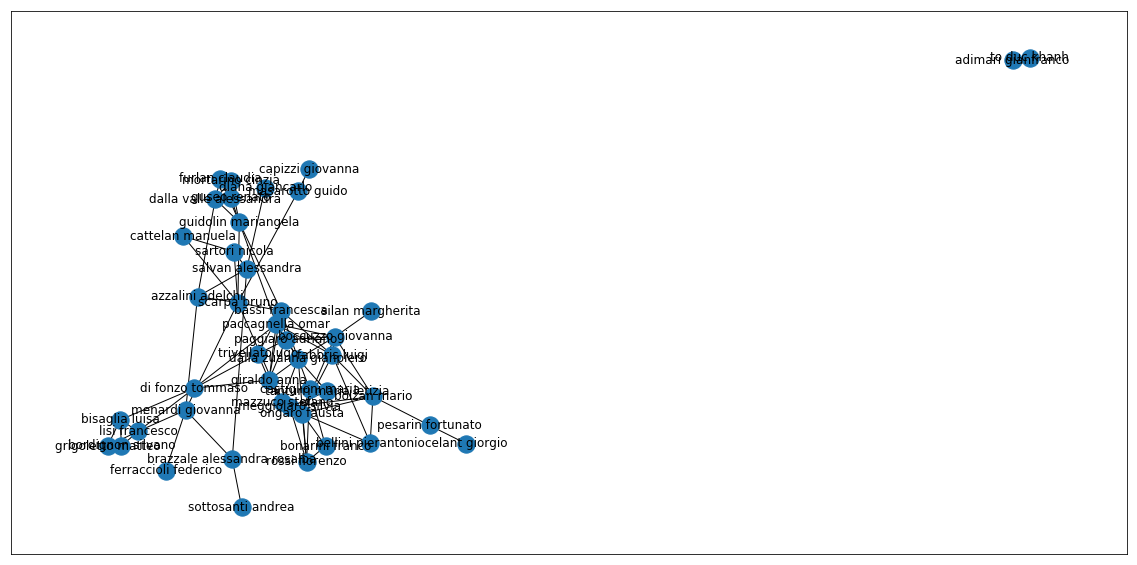

In [24]:
figure(figsize=(20, 10))
pos = nx.spring_layout(G)
nx.draw_networkx(G=G, pos=pos)
plt.show()
warnings.filterwarnings("ignore")

### 4.3 Community detection

Use the Louvain method to identify the different communities and calculate the modularity of this partitioning.

In [25]:
louvain = community.best_partition(G)
mod = community.modularity(louvain, G)
print(mod)

0.7057744753920355


### 4.4 Calculation of the betweenness of the nodes

In [26]:
btw = nx.betweenness_centrality(G)

### 4.5 Representation of the graph (parameterizing the size and colors of the nodes)

Represent the graph again by parameterizing:
* the color of the nodes: determined by the community
* the size of the nodes: determined by the betweenness

In [27]:
color_N = list(louvain.values())
pos = nx.spring_layout(G)
btw_val = np.array(list(btw.values()))
scaler = MinMaxScaler((100, 1000))
dim_N = scaler.fit_transform(btw_val.reshape(-1, 1))

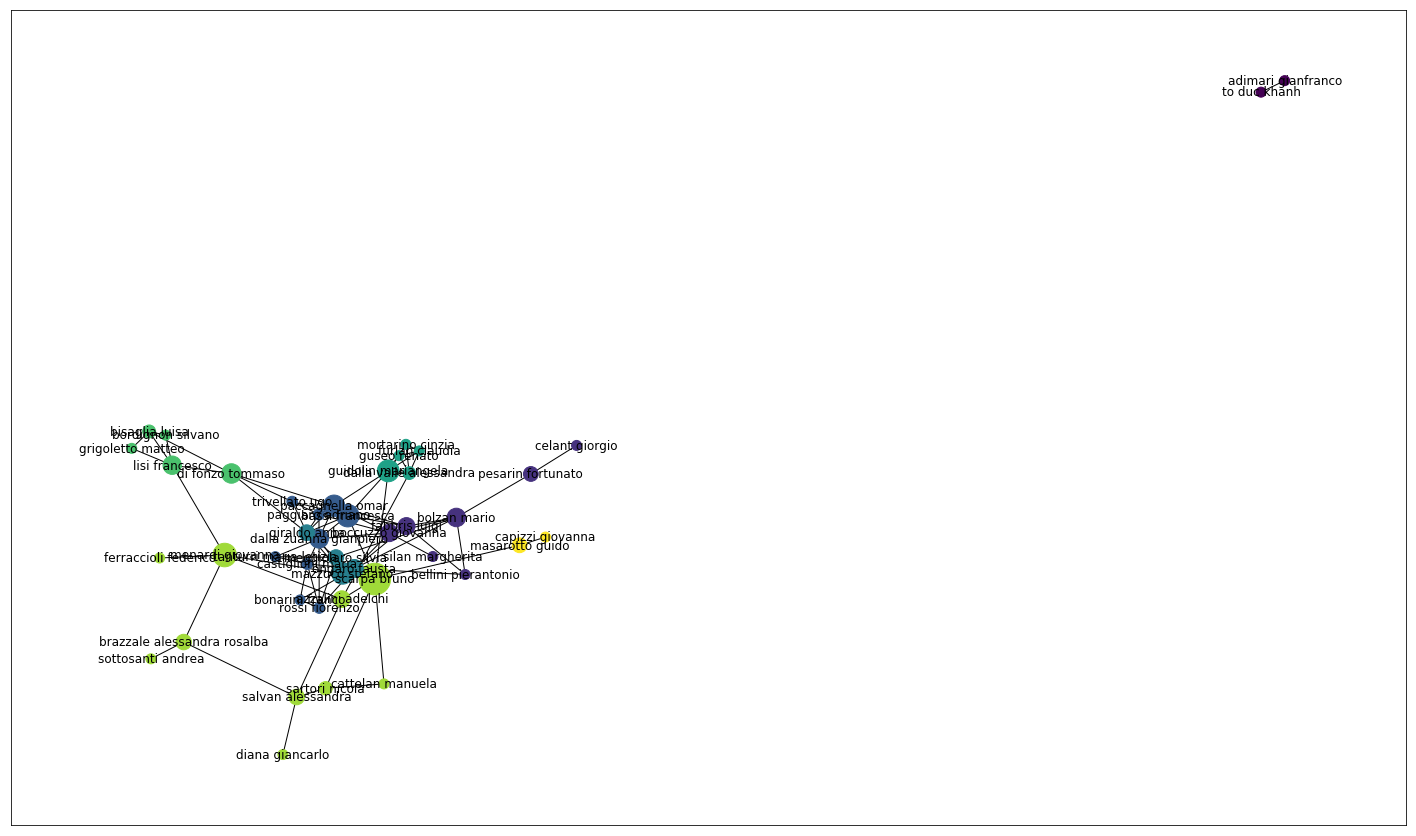

In [28]:
figure(figsize=(25, 15))
nx.draw_networkx(G=G, pos=pos, node_color=color_N, node_size=dim_N)
plt.show()